# INTRODUCTION
**Author: Antoine Dumont Neira**

**Last Update: July 2024**

This is an example notebook with the basic setup required to run my wiggle corrector code for NIRSpec data. So far this code work for the 170lp and 290lp filters

1. The model for the wiggles consist of multiple sinudoidal fits of the form f(x) = $A\times \cos(2 \pi f_{\omega} + \phi)$ at chunks of wavelenghts of $\sim 0.1 \mu m$. This part is done in the same manner as described in the code of M. Perna presented in https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..89P/abstract and available in the Github: https://github.com/micheleperna/JWST-NIRSpec_wiggles?tab=readme-ov-file.

2. The code presented here should be regarded as an upgraded version of that code, with the main differences between the two listed below:
    >2.1. The reference spectrum, or in other words, the model of how the spectrum would look without wiggles in the Perna code was made of only an annular spectrum. In this code is a mixture of an **annular spectrum + an enlarged anular spectrum**$ ^{*}$ **+ Power-Law + 2nd degree polynomial**. This ensures that we can model corretly for changing on the slope of the continuum and equivalent width of stellar/gas features between the model and the data. 
    
    >2.2. The sinusoidal model is (x) = $A\times \cos(2 \pi f_{\omega} + \phi)$ plus a constant, same than at the code of M. Perna. This model is only used for obtaining the Amplitud, Frequency and phase of the cosine function while allowing to also model mismatches between the spectrum and the model described in point 2.1. However, the final model that is subtracted from the data does not include this continuum parameter, this prevents changing the shape of the continuum, a problem that I encountered with the code of M. Perna.

    >2.3 How we identify the pixels affected by wiggles. While the data that M. Perna analized in  https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..89P/abstract was a bright Quasar, and the wiggles are produced from an undersampling of the PSF for point sources, a simple Signal-to-Noise cut was done to trace "Quasar" light and then pixels with wiggles. We can imagine that this does not holds up for all point sources, specially where the point source is not dominant, for example the case of a Low-luminosity AGN. 
    Therefore, **this code flaggs pixels affected by wiggles based on their Fourier Transform**. The frequewncy of wiggles is fairly stable for different type of data, presenting large peaks on frequncies of 5-50 $[1/\mu m]$. In this code I compare the Fourier transform of the annular spectrum ( that traces frequencies associated with real physical process) with the rest of the spectrum, and compare the ratio of the amplitud of the FFT spectrum in the 5-50 $[1/\mu m]$ range. Normally, pixels with a ratio of 3-sigma enhancement are flagged as affected heavily by wiggles, however the user can set the threshold by hand. 

    >2.4 Another change worth mentioning is that the code is written on a Python class and not just as a jupyter notebook, this makes the user experience much simpler and also the codes is written fully parallelized, reducing the time for running significantly!.


## **STEP 0**: SETUP BASIC PARAMETERS

Setup basic information, such as redshift, jwst filter, path to rhe datacube, etc

In [1]:
run Main.py

The **redshift z** is only relevant if the user uses the **"linefeatures.dat"** file with known emission/absorption lines (all in vaccuum), so the code can find the right shift to mask the regions around this lines. 

The user can modify the  **"linefeatures.dat"** file to add or remove lines they want, and to use it just set the keyword **linefeatures = True**

In [2]:
pathcube_input= "/Users/dumont/Documents/ReveaLLGN/DATA/LBQS0302-0019/jw01220-o002_t002_nirspec_g235h-f170lp/"
cube_input  = "jw01220-o002_t002_nirspec_g235h-f170lp_s3d.fits"
sourcename = "LBQS0302-0019+JIL"
z = 3.28485429322
jwst_filter = 'f170lp' ### Or f290lp 

fit_wiggles_170lp = setup(Object_name=sourcename,
                                    pathcube=pathcube_input,cube_path=cube_input,
                                    redshift=z,jwst_filter=jwst_filter)



### Find the center of the datacube

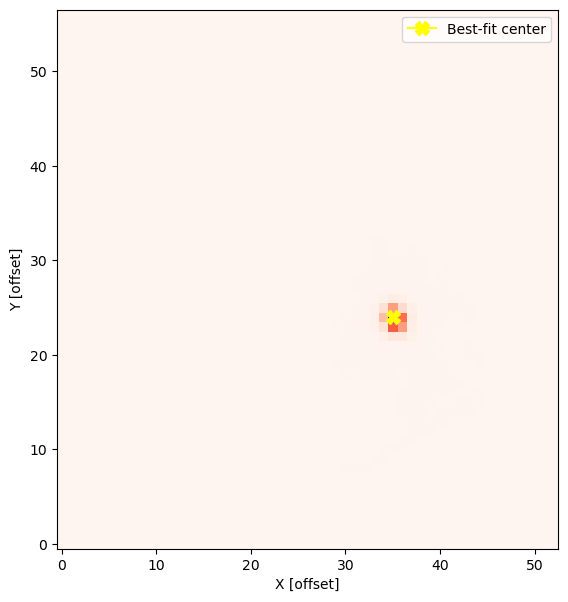


 Center is  x, y =  35 24


In [3]:
fit_wiggles_170lp.get_center(do_plots=True)

#### **MASK BAD REGIONS** 
The code performs automated emission line detection. The user can define the minimum S/N and width (in pixels) to flag an emission line. Additionally, the user can also provide a file named "linefeatures_vac.dat" that contains known emission and absorption lines, such as CO bandhead, etc.

The continuum window, as its name suggests, is used to calculate the continuum in the cosine function described in section 2.2. Please avoid large emission lines, etc. The gap between the two chips is automatically masked.

Here is a quick example of the parameters you can define to get a better fit:

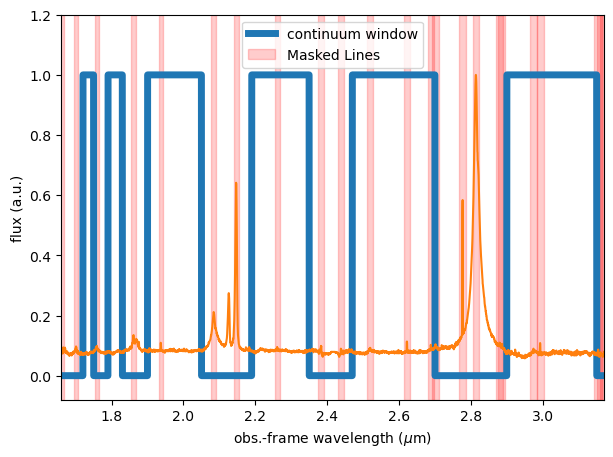

In [7]:
### CHANGE DEFAULT WAVELENGHT WINDOWS TO CALCULATE SHAPE OF THE CONTINUUM. PLEASE TRY TO AVOID BIG EMISSION LINES
fit_wiggles_170lp.con_to_be_subtracted = [[1.72,1.75],[1.79,1.83],
                                          [1.9,2.05],[2.19,2.35],
                                          [2.47,2.7],[2.9,3.15]] # In microns
##############################################################################################################
fit_wiggles_170lp.min_peak_snr = 2 # Min Signal to noise of line to be masked
fit_wiggles_170lp.peak_width = 4  # Min width in pixels of emission line to be masked
fit_wiggles_170lp.DV = 1000 ## This quasar has quite broad lines so I Increase default width (in km/s) around an emission/absoprtion
fit_wiggles_170lp.get_reference_spectrum(in_radius=2,out_radius=7,do_plots=True)

# **STEP 2:** FIT WIGGLES FOR CENTRAL PIXEL

Here I perform the fitting only on the central pixel. This model will be used later as prior for the Frequewncy, amplitud and continuum for the sinusoidal fiting for the rest of the pixels in the datacube. 

**IMPORTANT!!** Please based on this plot choose a side of the chip that the wiggles are more prevalent. In my experience in the f170lp filter the right chip wiggles are more clear and the opposite for the f290lp. 

based on your choice set **chip_side** either to **"det1"** (left) or **"det2"** (right). Default I set it up to the convention I mentioned above. 

Fitting routine requires 3 iterationes to achieve a good result. 

iteration n.  0


/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FitWiggles.py:432: RuntimeWarning: divide by zero encountered in scalar divide
  chi2red = chisquare(m.params,x_model[flag_mod], wave[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave[flag_mod].size - m.params.size)
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FitWiggles.py:444: RuntimeWarning: divide by zero encountered in scalar divide
  chi2red_new = chisquare(m0.params,x_model[flag_mod], wave[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave[flag_mod].size - m0.params.size)
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FitWiggles.py:444: RuntimeWarning: divide by zero encountered in scalar divide
  chi2red_new = chisquare(m0.params,x_model[flag_mod], wave[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave[flag_mod].size - m0.params.size)
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIG

ITERATION 0 OF 2 FINISHED
iteration n.  1
error message =  ERROR: number of parameters must not exceed data


/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FitWiggles.py:432: RuntimeWarning: divide by zero encountered in scalar divide
  chi2red = chisquare(m.params,x_model[flag_mod], wave[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave[flag_mod].size - m.params.size)
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FitWiggles.py:444: RuntimeWarning: divide by zero encountered in scalar divide
  chi2red_new = chisquare(m0.params,x_model[flag_mod], wave[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave[flag_mod].size - m0.params.size)
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FitWiggles.py:444: RuntimeWarning: divide by zero encountered in scalar divide
  chi2red_new = chisquare(m0.params,x_model[flag_mod], wave[flag_mod], spec_to_be_modelled[flag_mod], espec[flag_mod])/(wave[flag_mod].size - m0.params.size)
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIG

ITERATION 1 OF 2 FINISHED


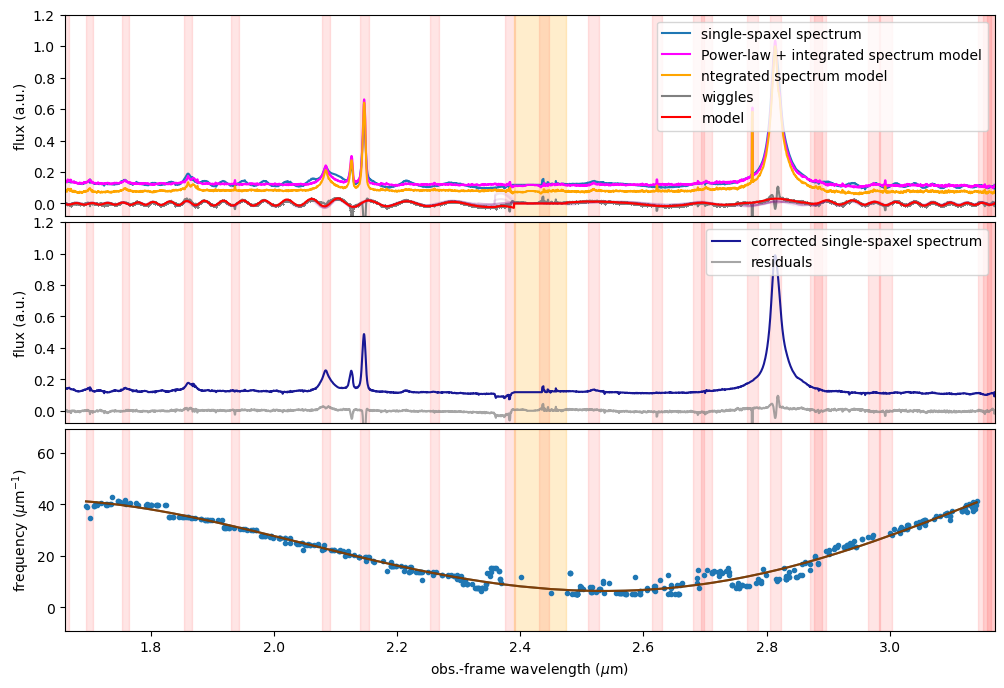

In [8]:

fit_wiggles_170lp.FitWigglesCentralPixel(N_rep=15) 


# **STEP 2:** IDENTIFY PIXELS WITH WIGGLES


By default, the code only searches for wiggles within a circle of radius 12 pixels around the center of the cube. Since wiggles are associated with the central point source, they are not expected to be found at much larger radii.

/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:163: RuntimeWarning: All-NaN slice encountered
  spec = np.nan_to_num( cube[:,y,x], nan= np.nanmedian(cube[:,y,x][self.con_windows]))
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:164: RuntimeWarning: All-NaN slice encountered
  espec =  np.nan_to_num( ecube[:,y,x] , nan= np.nanmedian(ecube[:,y,x][self.con_windows]) )


WARNING BAD PIXEL. PIXEL 10 10 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 11 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 12 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 13 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 14 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 15 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 16 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 17 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 18 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 19 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 20 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 21 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 22 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 23 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 24 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 25 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 26 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 27 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 28 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 29 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 30 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 31 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 32 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 33 SKIPPED!
WARNING BAD PIXEL. PIXEL 10 34 SKIPPED!


/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:163: RuntimeWarning: All-NaN slice encountered
  spec = np.nan_to_num( cube[:,y,x], nan= np.nanmedian(cube[:,y,x][self.con_windows]))
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:164: RuntimeWarning: All-NaN slice encountered
  espec =  np.nan_to_num( ecube[:,y,x] , nan= np.nanmedian(ecube[:,y,x][self.con_windows]) )
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:163: RuntimeWarning: All-NaN slice encountered
  spec = np.nan_to_num( cube[:,y,x], nan= np.nanmedian(cube[:,y,x][self.con_windows]))
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:164: RuntimeWarning: All-NaN slice encountered
  espec =  np.nan_to_num( ecube[:,y,x] , nan= np.nanmedian(ecube[:,y,x][self.con_windows]) )
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FI

WARNING BAD PIXEL. PIXEL 13 10 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 11 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 12 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 13 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 14 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 15 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 16 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 17 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 18 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 19 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 20 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 21 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 22 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 23 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 24 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 25 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 26 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 27 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 28 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 29 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 30 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 31 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 33 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 34 SKIPPED!
WARNING BAD PIXEL. PIXEL 13 35 SKIPPED!


/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:163: RuntimeWarning: All-NaN slice encountered
  spec = np.nan_to_num( cube[:,y,x], nan= np.nanmedian(cube[:,y,x][self.con_windows]))
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:164: RuntimeWarning: All-NaN slice encountered
  espec =  np.nan_to_num( ecube[:,y,x] , nan= np.nanmedian(ecube[:,y,x][self.con_windows]) )
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:163: RuntimeWarning: All-NaN slice encountered
  spec = np.nan_to_num( cube[:,y,x], nan= np.nanmedian(cube[:,y,x][self.con_windows]))
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:164: RuntimeWarning: All-NaN slice encountered
  espec =  np.nan_to_num( ecube[:,y,x] , nan= np.nanmedian(ecube[:,y,x][self.con_windows]) )


WARNING BAD PIXEL. PIXEL 14 33 SKIPPED!
WARNING BAD PIXEL. PIXEL 14 34 SKIPPED!
WARNING BAD PIXEL. PIXEL 14 35 SKIPPED!
WARNING BAD PIXEL. PIXEL 14 39 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 10 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 11 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 12 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 13 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 14 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 15 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 16 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 17 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 18 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 19 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 20 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 21 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 22 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 23 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 24 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 25 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 26 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 27 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 28 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 29 SKIPPED!
WARNING BAD PIXEL. PIXEL 15 30 SKIPPED!


/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:163: RuntimeWarning: All-NaN slice encountered
  spec = np.nan_to_num( cube[:,y,x], nan= np.nanmedian(cube[:,y,x][self.con_windows]))
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:164: RuntimeWarning: All-NaN slice encountered
  espec =  np.nan_to_num( ecube[:,y,x] , nan= np.nanmedian(ecube[:,y,x][self.con_windows]) )


WARNING BAD PIXEL. PIXEL 16 10 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 11 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 12 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 13 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 14 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 15 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 16 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 17 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 18 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 19 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 20 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 21 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 22 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 23 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 24 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 25 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 26 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 27 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 28 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 29 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 30 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 31 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 32 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 33 SKIPPED!
WARNING BAD PIXEL. PIXEL 16 34 SKIPPED!


/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:163: RuntimeWarning: All-NaN slice encountered
  spec = np.nan_to_num( cube[:,y,x], nan= np.nanmedian(cube[:,y,x][self.con_windows]))
/Users/dumont/Documents/ReveaLLGN/MODEL/FittWiggles/FINAL WIGGLE MODEL/Github/FIndWiggles.py:164: RuntimeWarning: All-NaN slice encountered
  espec =  np.nan_to_num( ecube[:,y,x] , nan= np.nanmedian(ecube[:,y,x][self.con_windows]) )


WARNING BAD PIXEL. PIXEL 17 10 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 11 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 12 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 13 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 14 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 15 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 16 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 17 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 18 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 19 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 20 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 21 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 22 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 23 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 24 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 25 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 26 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 27 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 28 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 29 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 30 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 31 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 32 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 34 SKIPPED!
WARNING BAD PIXEL. PIXEL 17 35 SKIPPED!


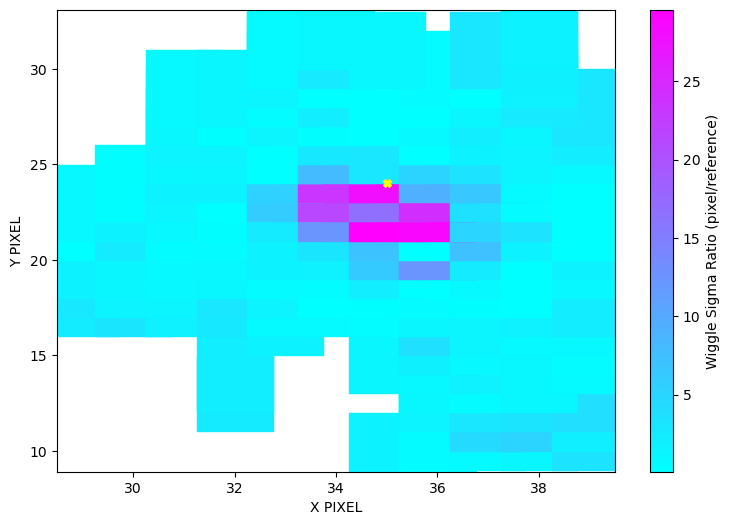

In [9]:
from FIndWiggles import fit_wiggly_spaxels, get_wiggly_pixels
chip_side = "right"

results = get_wiggly_pixels(fit_wiggles_170lp, N_Cores=7,chip_side=chip_side,do_plots=True)



### **Examine the FFT to define threshold**

This step is not mandatory, here I make it as an example of how the user can study the data to determine an apropied sigma "threshold" above which pixels are flagg as having wiggles.
 
 Using **plot_wiggle_FFT** you can visualize the FFT used to calculate the wiggle ratio. This can be useful to vizualize a pixel that you may not be sure if should or not be corrected for wiggles. Based on the ratio of this pixel you can then define a "Threshold".

 The default "threshold" is 3. 

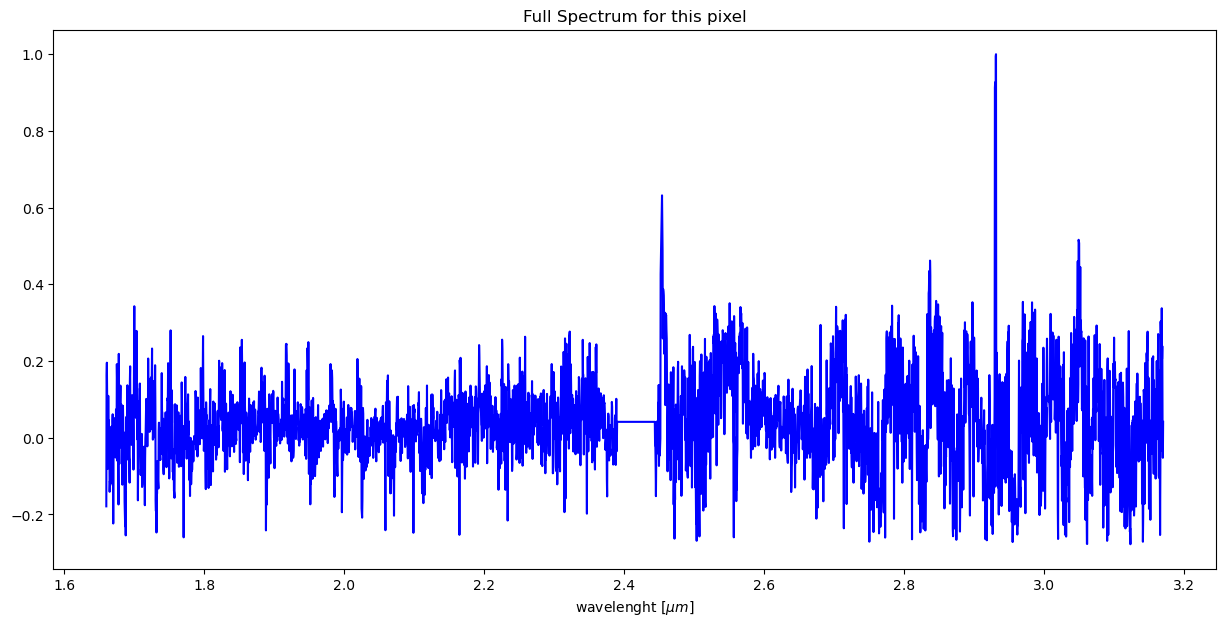


 Sigma Ratio = 4.227


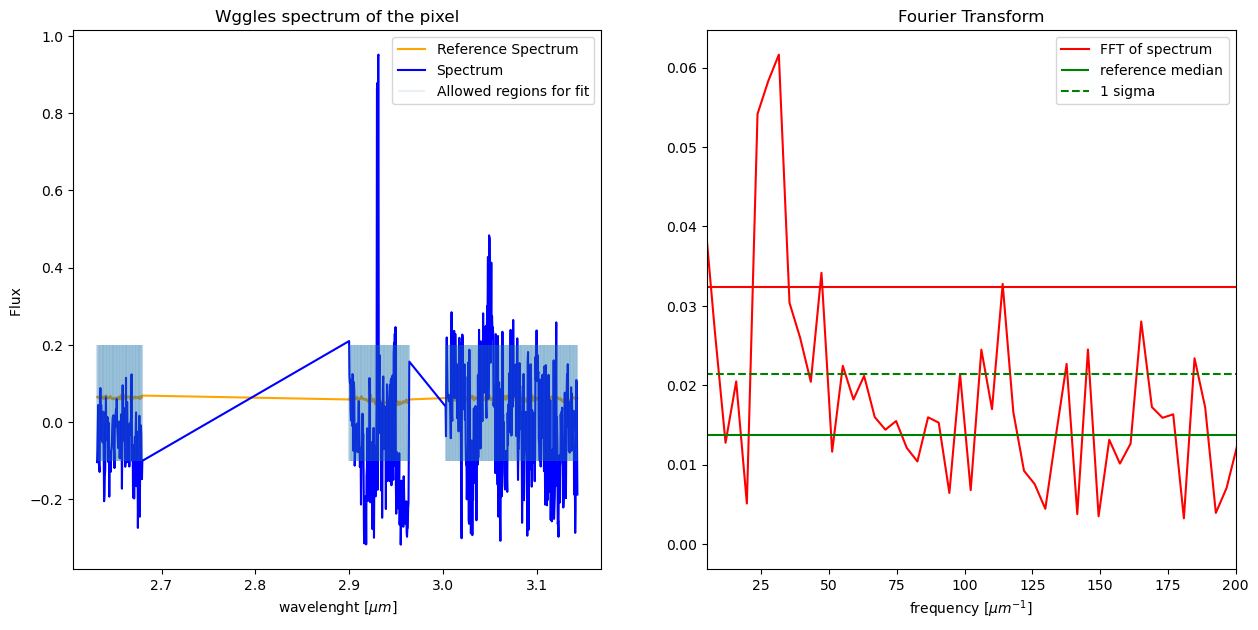

In [22]:
from FIndWiggles import plot_wiggle_FFT
X, Y = 37,12
plot_wiggle_FFT(fit_wiggles_170lp,X, Y,chip_side)

#### Here based on examining outer pixels I have decided on a threshold of 3


 24 PIXELS AFFECTED BY WIGGLES


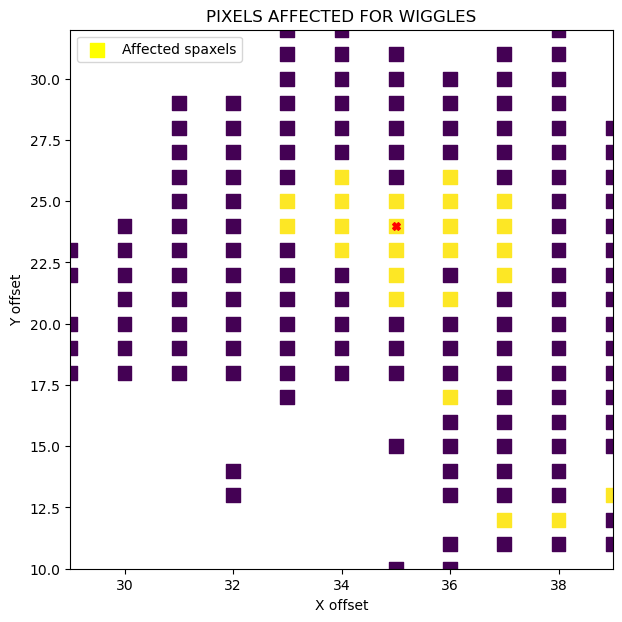

In [20]:
from FIndWiggles import define_affected_pixels
affected_pixels = define_affected_pixels(fit_wiggles_170lp,results,threshold=3.5)


If needed for later use you can save the list of flagged pixels by setting the arg **save_file=True**

Later you can load the file with the list of affected pixels as follow:

> import pandas as pd

> affected_pixels = pd.read_csv("affected_pixels.csv",header=None)

> affected_pixels = [[i,j] for (i,j) in zip(affected_pixels[0],affected_pixels[1])]

## **STEP 3:** CORRECT WIGGLES
Now that we have identified spaxels affected by wiggles, we need to obtain a model of their frequency.
For this we start by creating an informed guess of the frequency of the wiggles based on the central pixel, as it is the spaxel more affected by them.

This model of frequencies and amplitudes (for the cosine function) will be then used as a prior
for fitting the frequency and amplitude for the rest of affected pixels. 

Adding affected spaxels to multiprocessing.pool 


 ##### START WIGGLE CORRECTION ##### 

Correcting wiggles on task: 0 of 24
error message =  ERROR: number of parameters must not exceed data
error message =  ERROR: number of parameters must not exceed data
error message =  ERROR: number of parameters must not exceed data
error message =  ERROR: number of parameters must not exceed data
error message =  ERROR: number of parameters must not exceed data
Correcting wiggles on task: 1 of 24
Correcting wiggles on task: 2 of 24
Correcting wiggles on task: 3 of 24
error message =  ERROR: number of parameters must not exceed data
error message =  ERROR: number of parameters must not exceed data
Correcting wiggles on task: 4 of 24
Correcting wiggles on task: 5 of 24
Correcting wiggles on task: 6 of 24
Correcting wiggles on task: 7 of 24
error message =  ERROR: number of parameters must not exceed data
error message =  ERROR: number of parameters must not exceed data
error message =  ERROR: numb

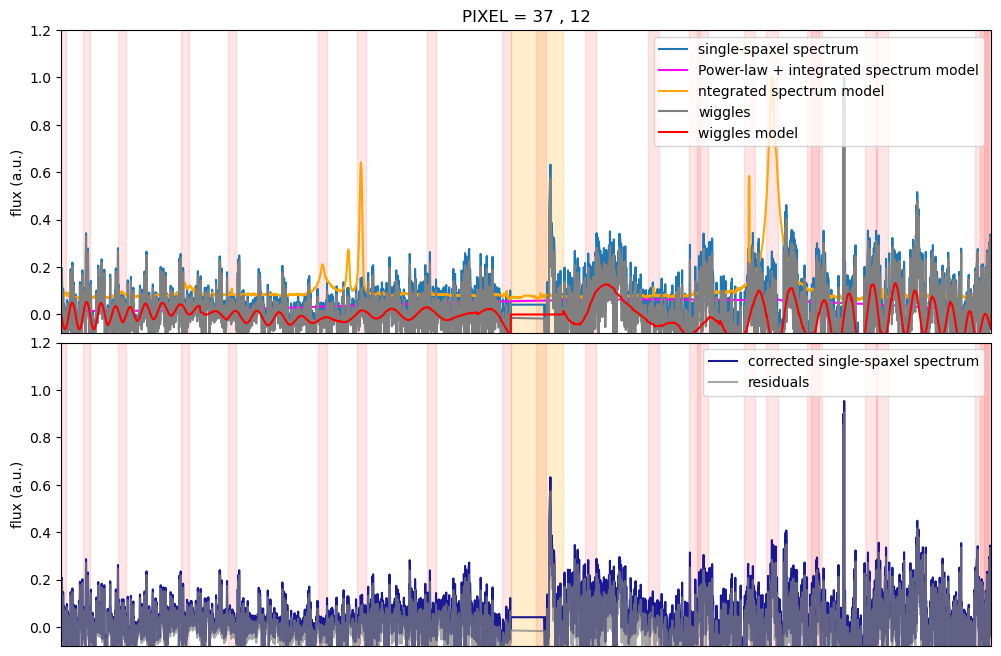

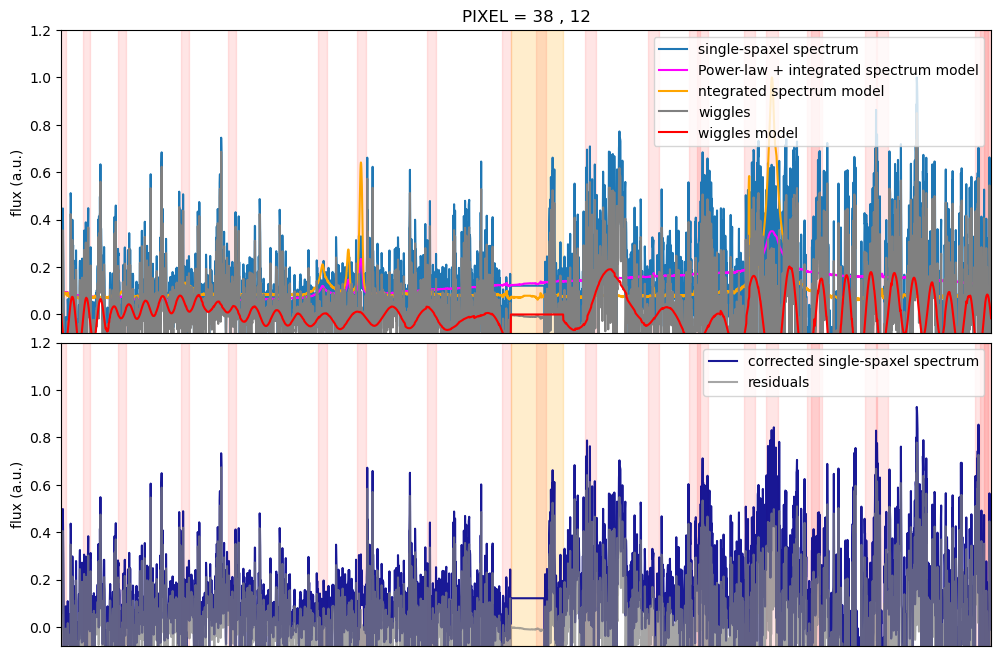

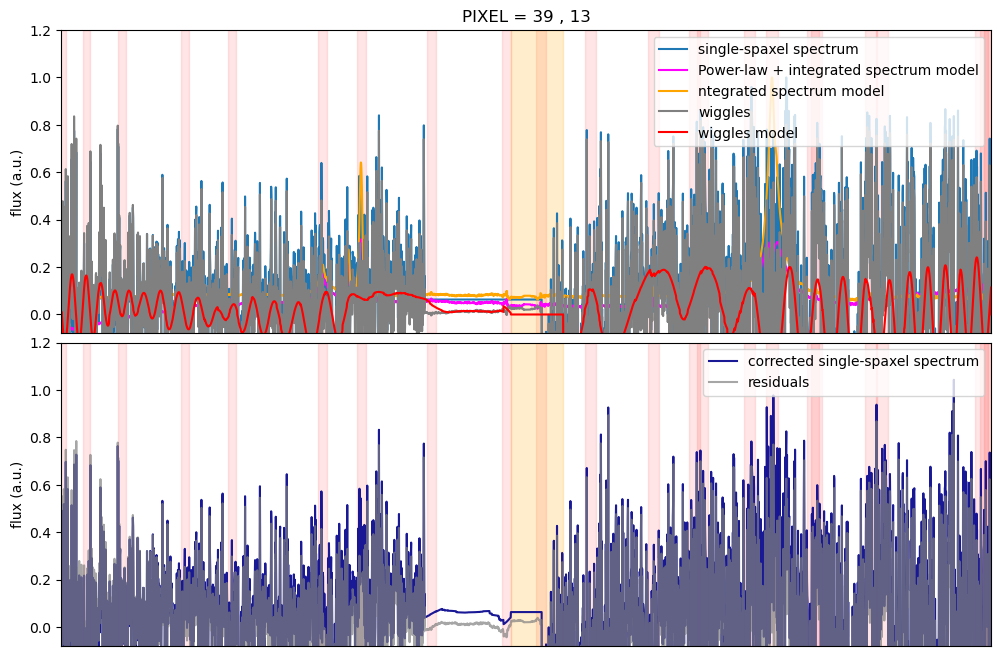

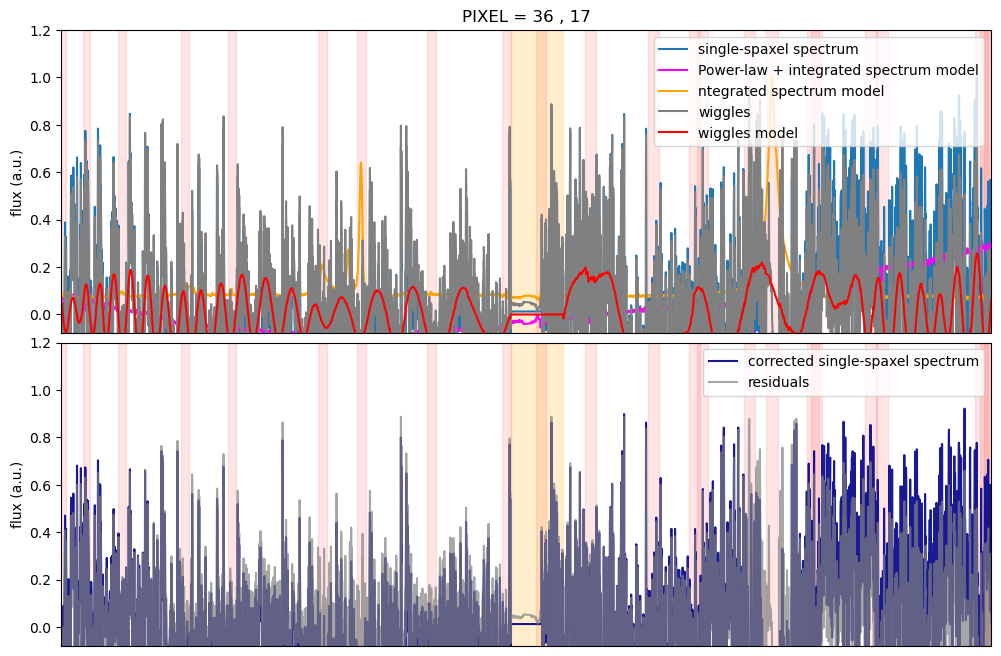

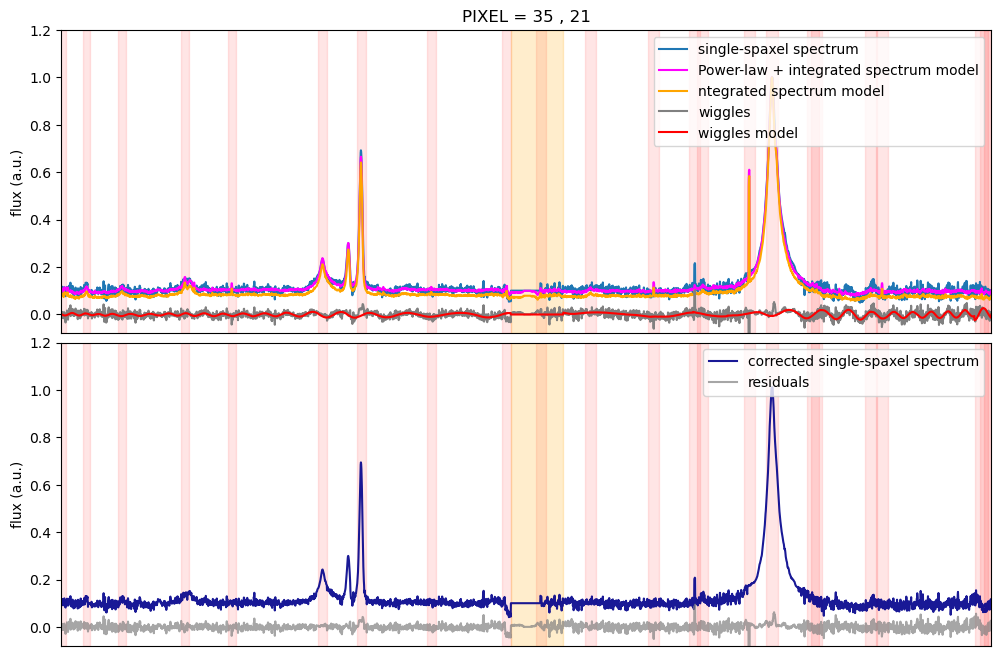

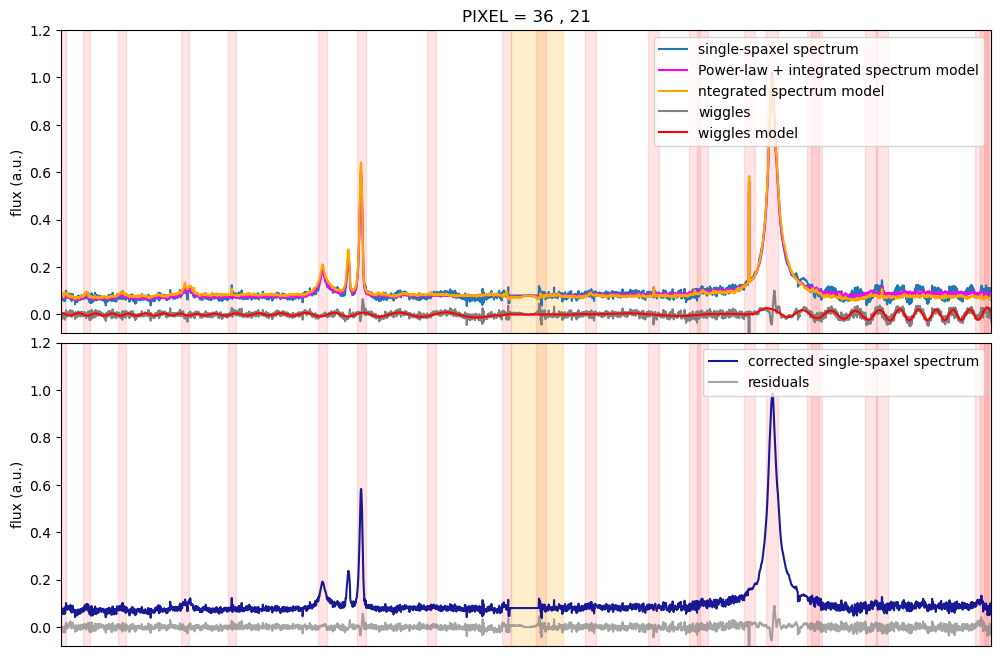

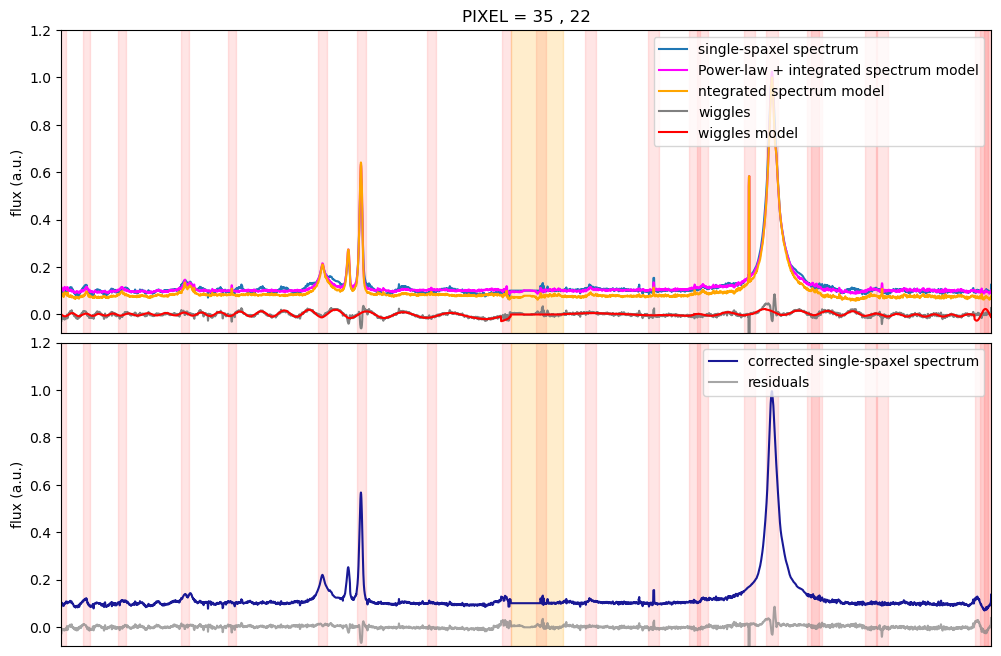

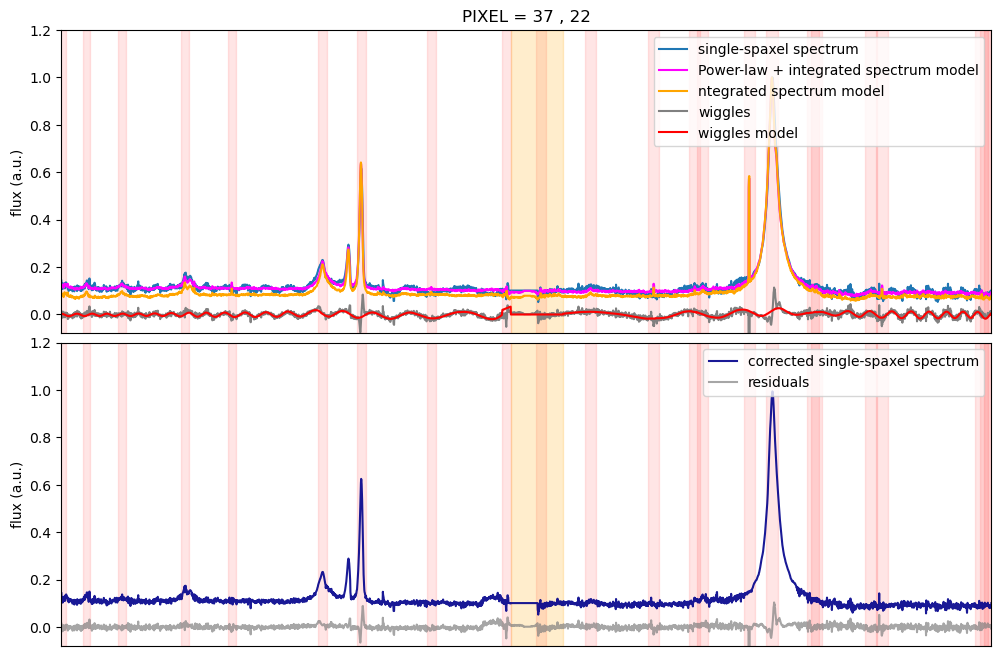

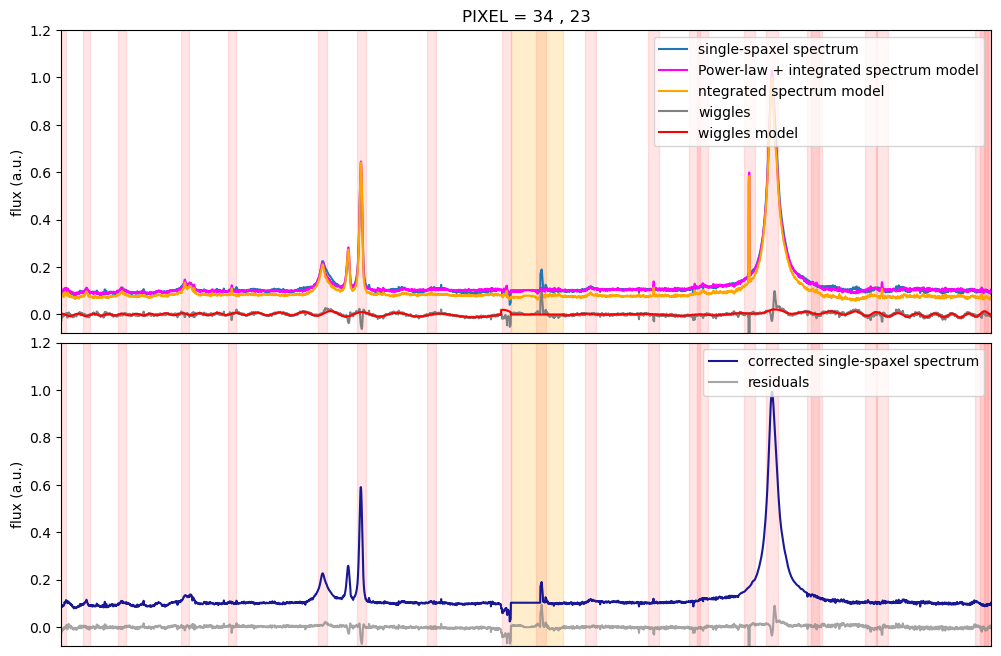

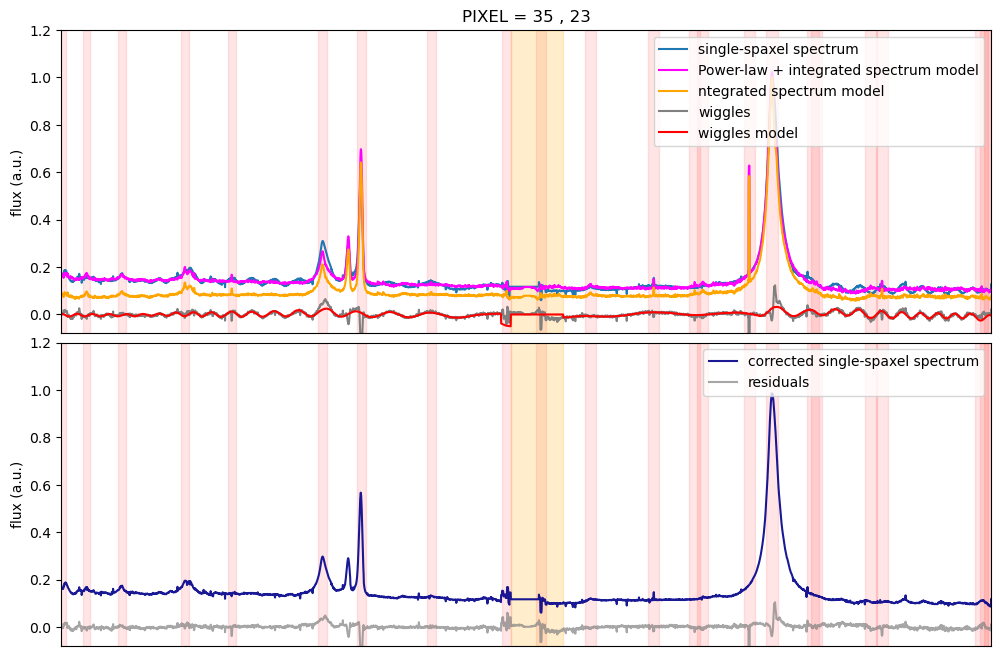

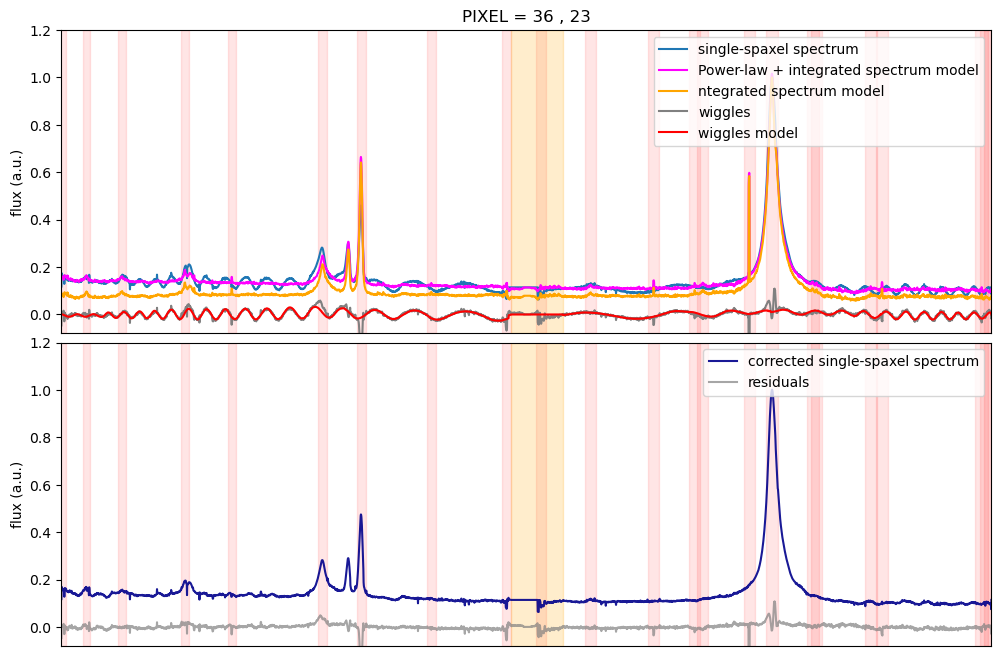

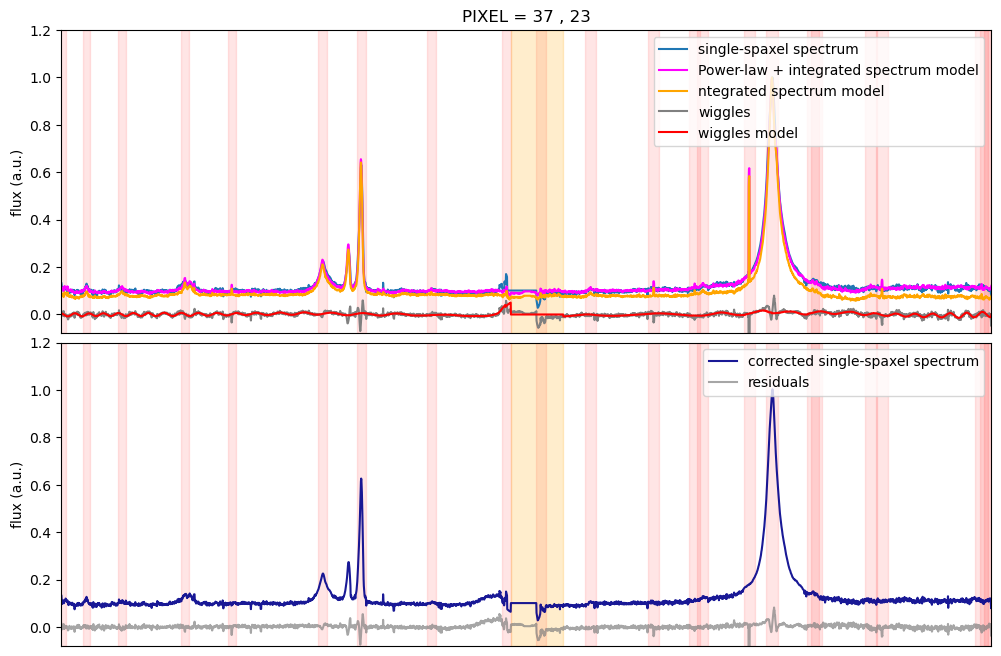

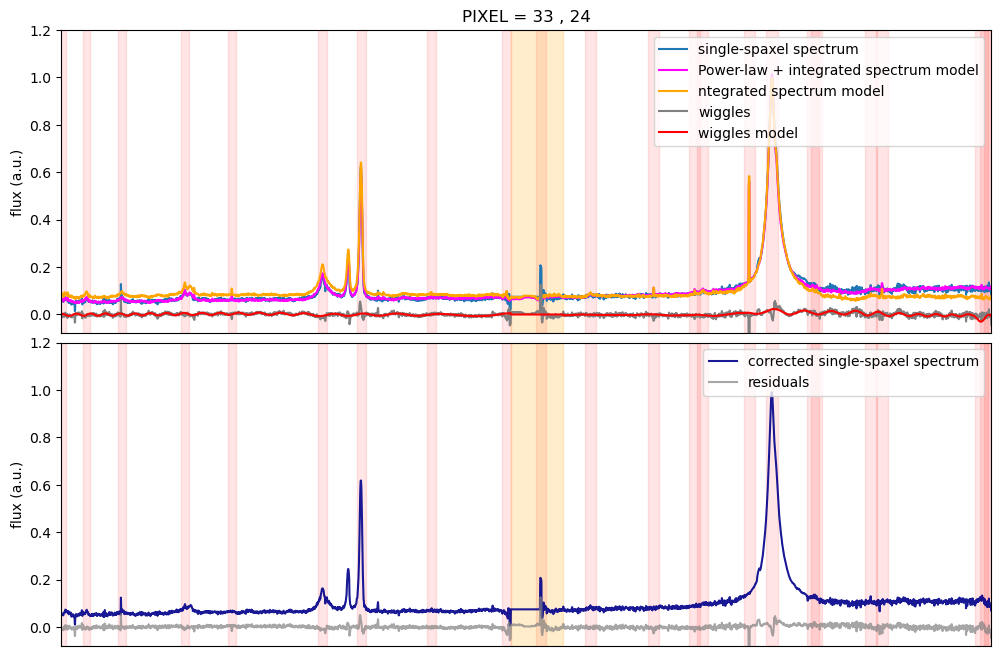

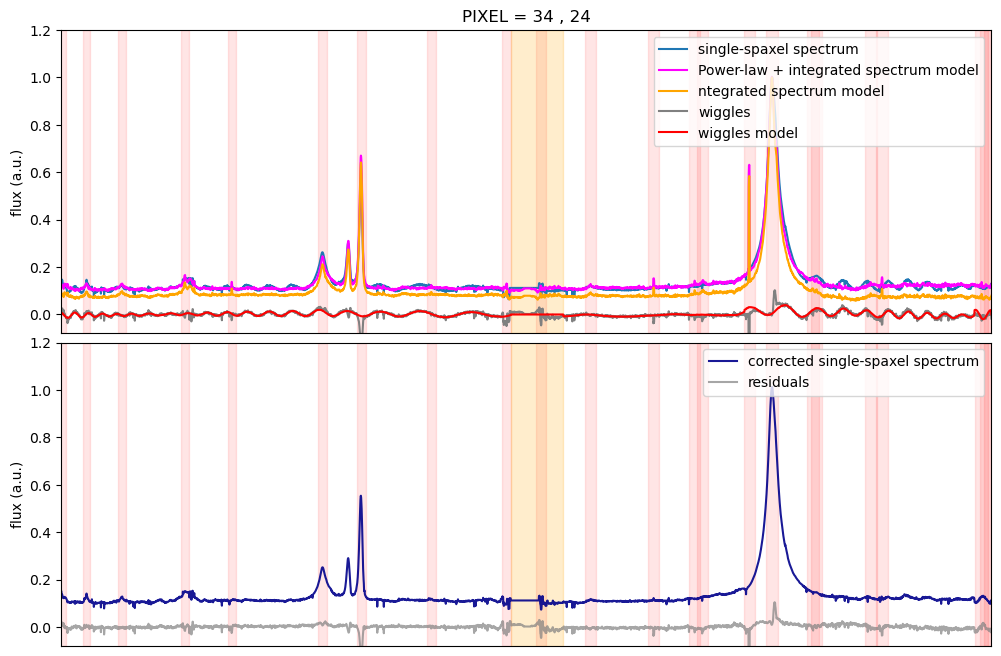

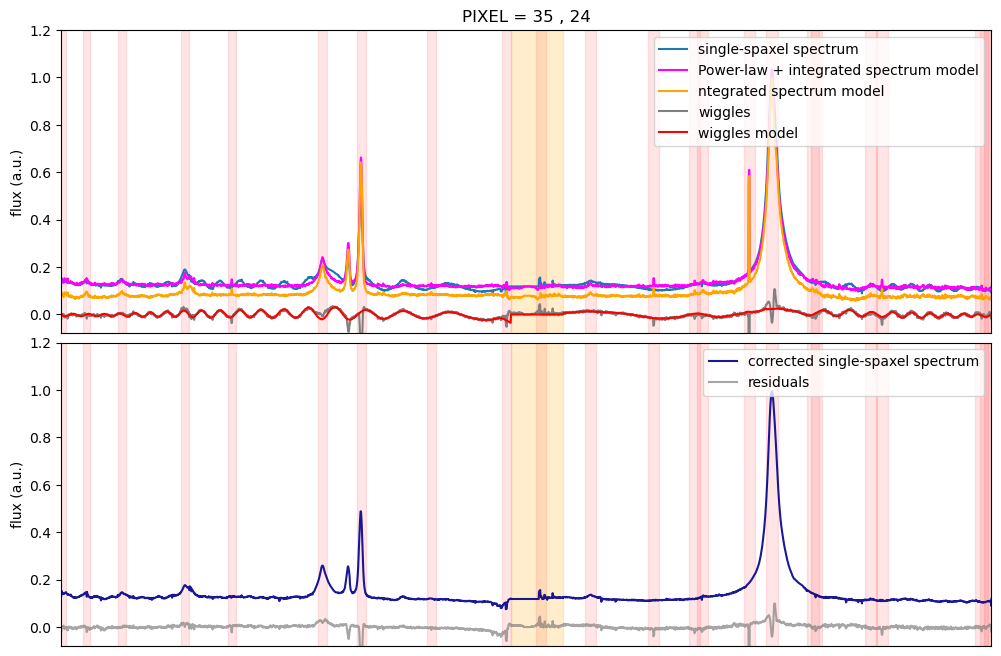

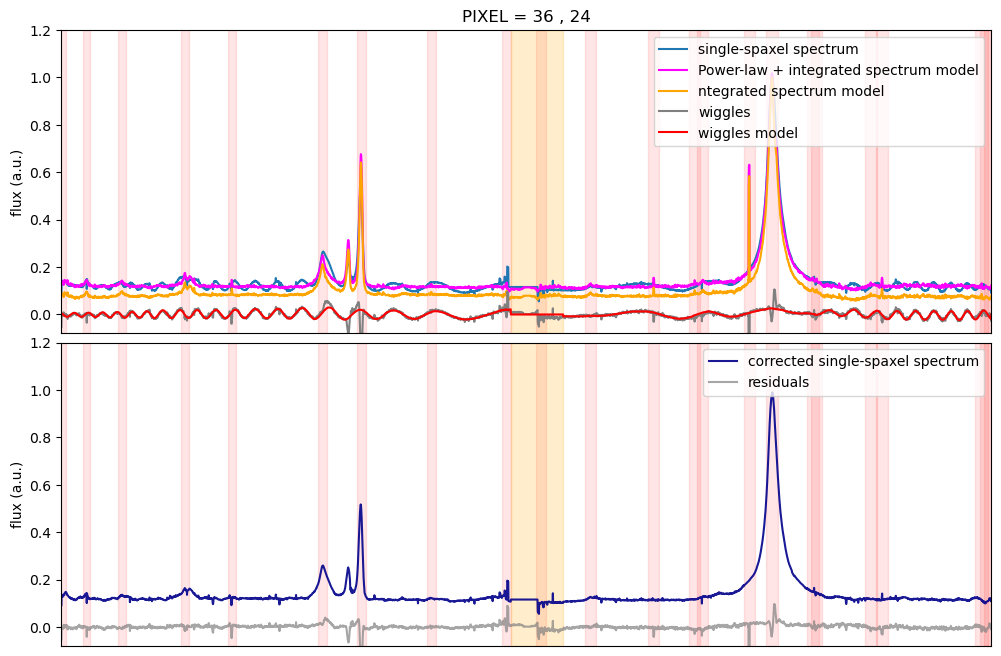

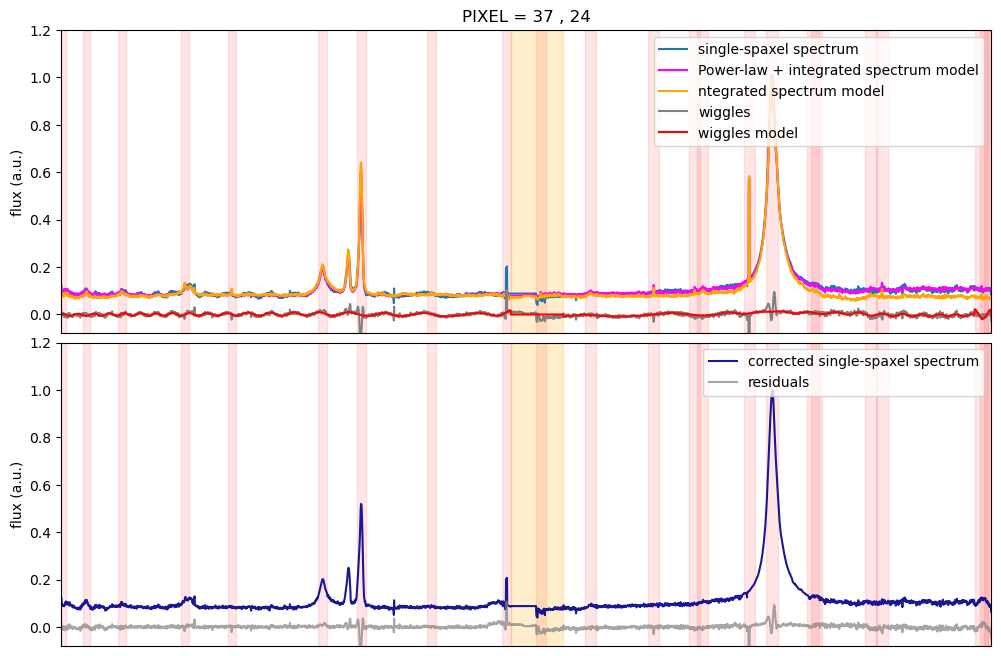

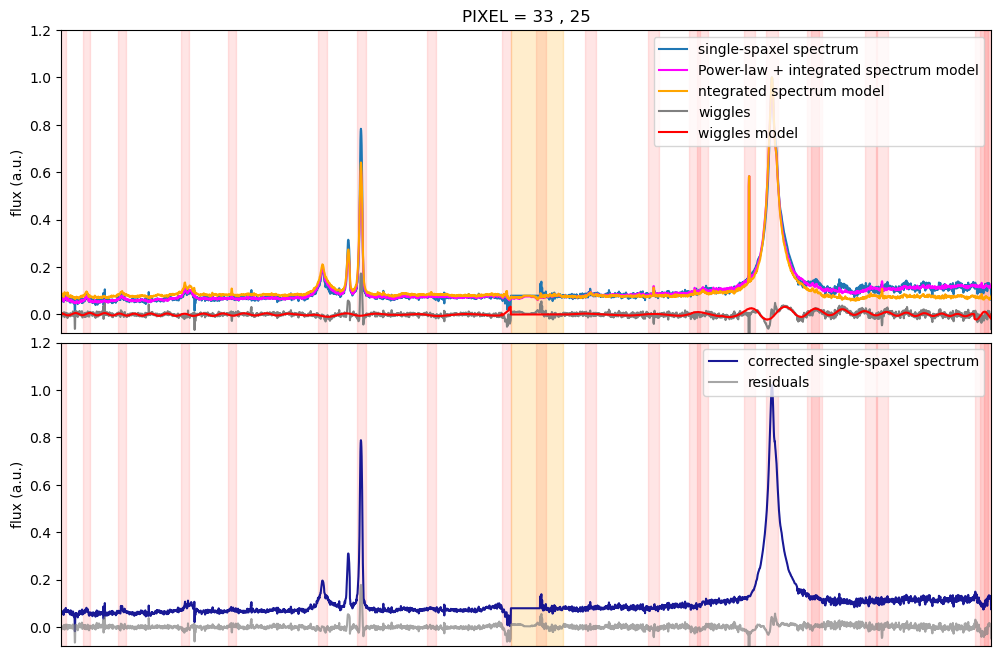

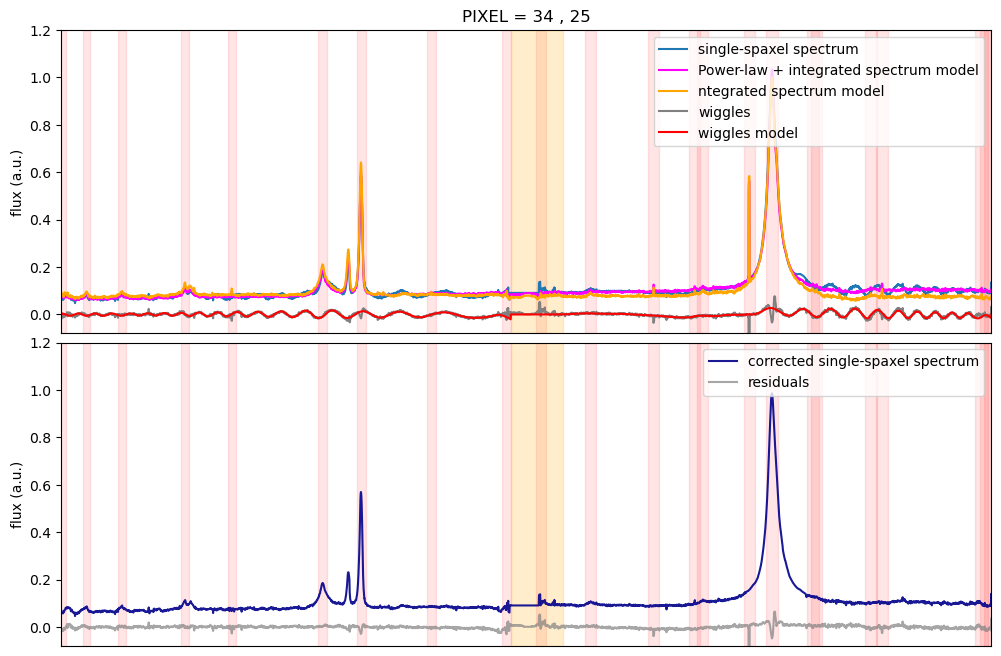

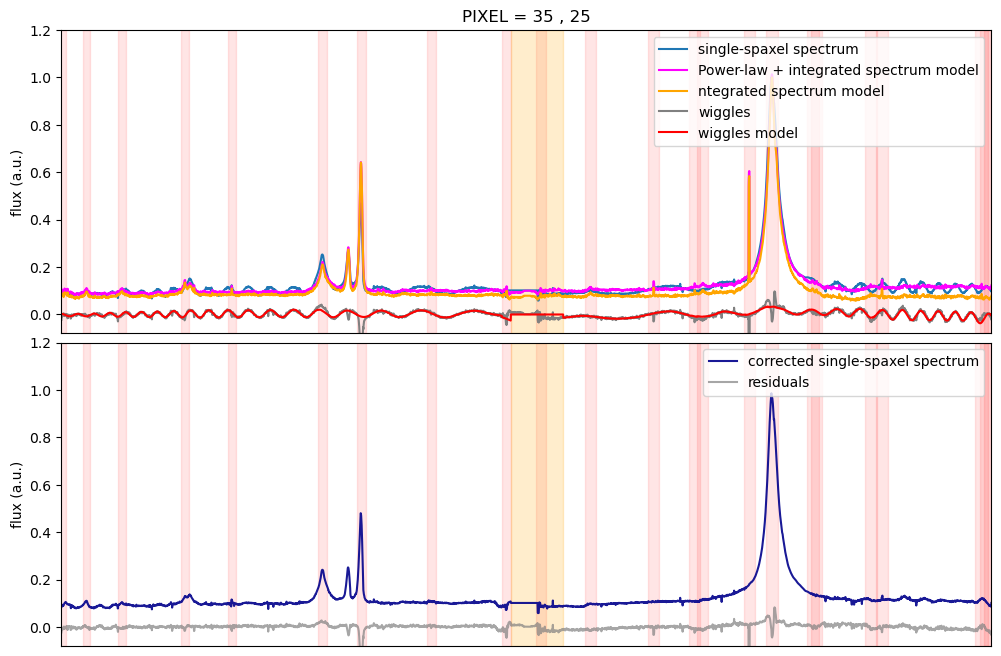

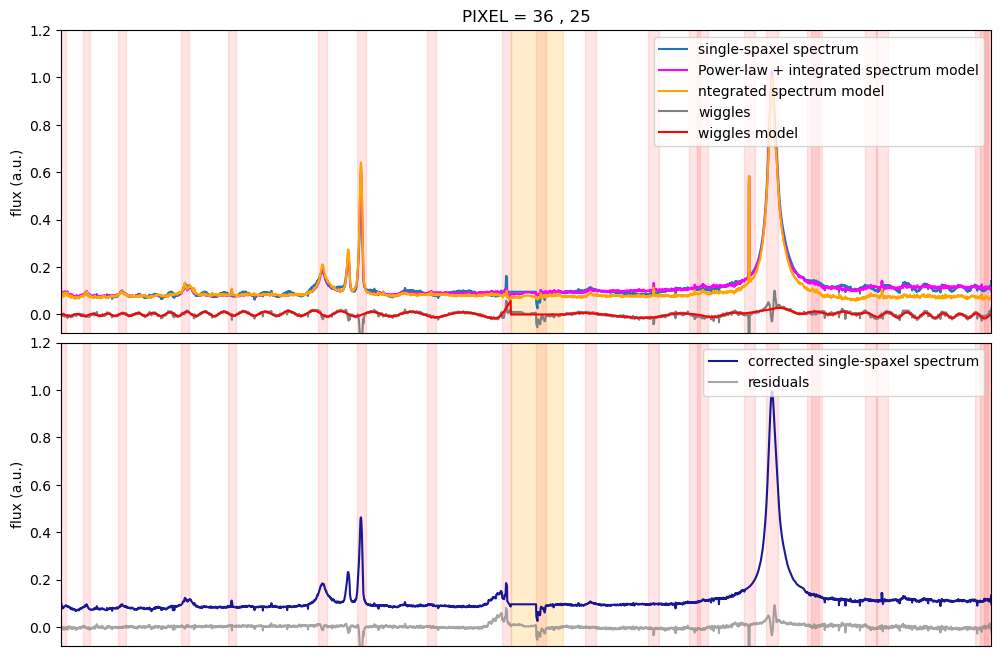

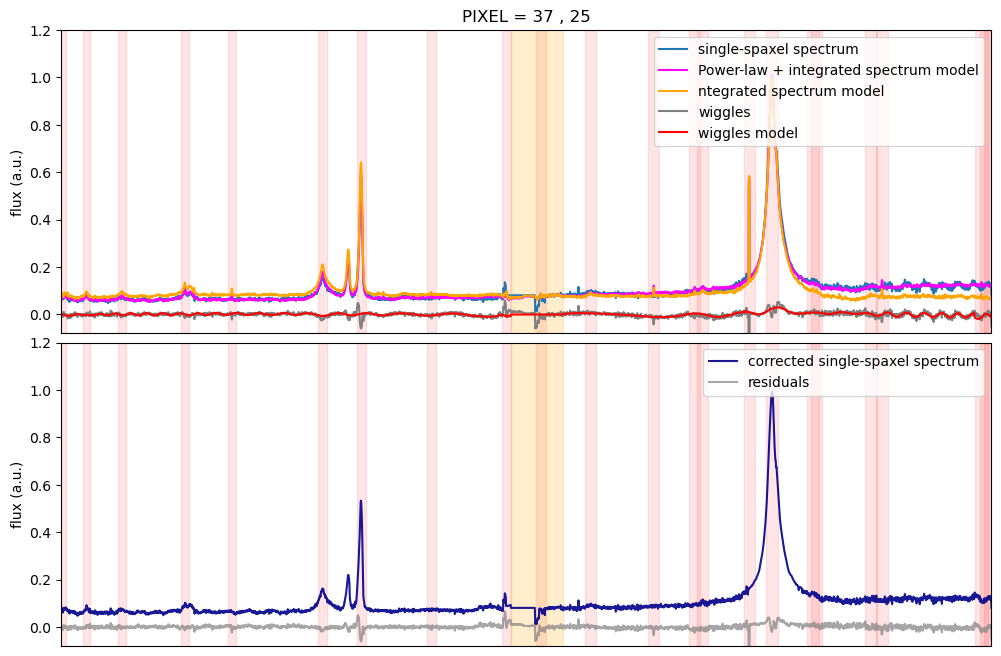

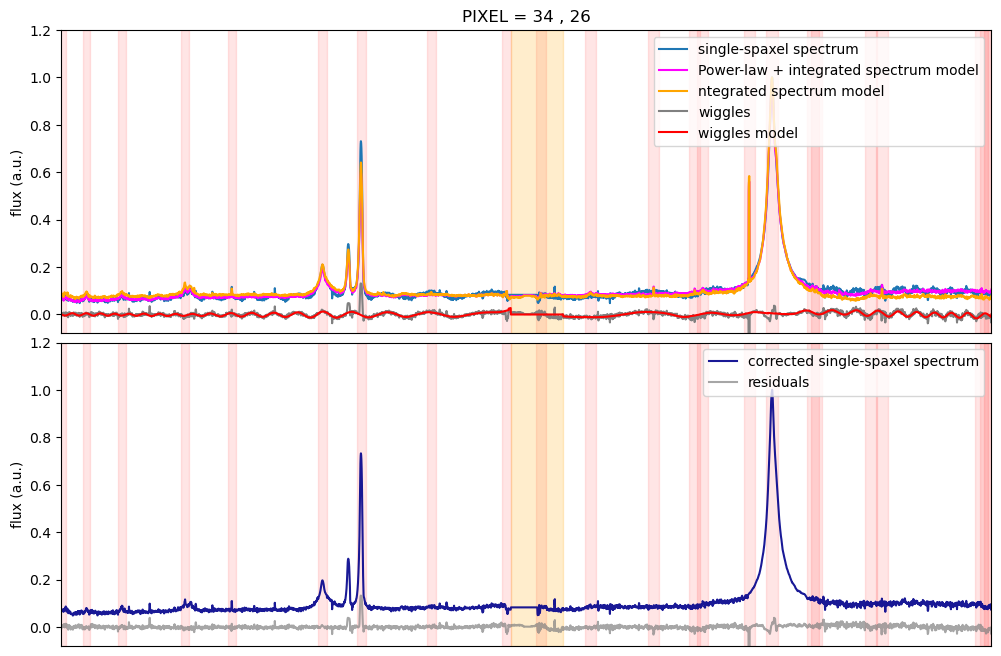

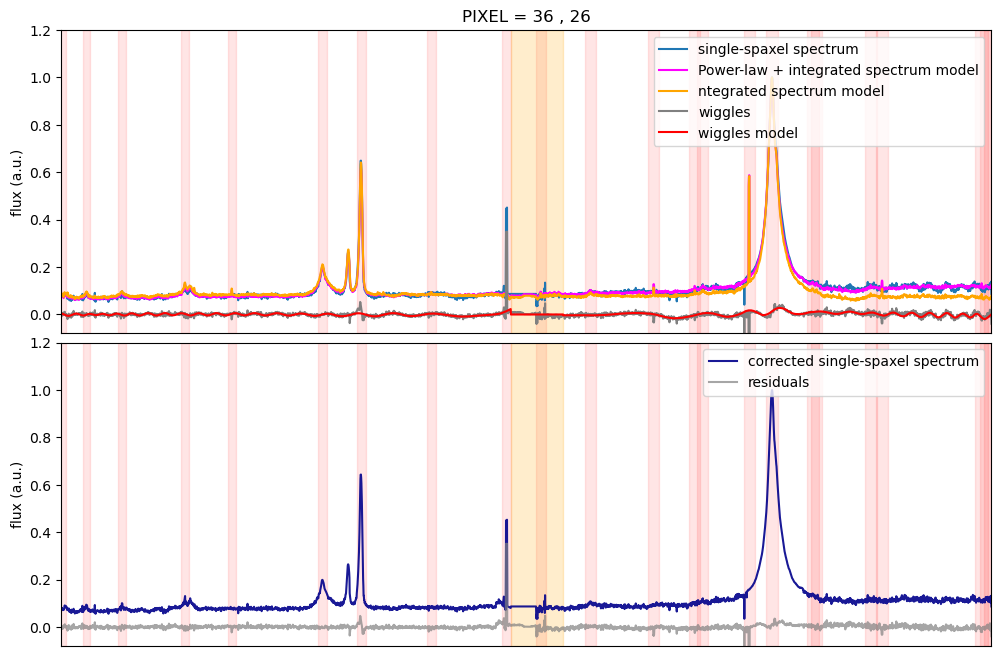

ADDING CORRECTED SPECTRA TO DATA CUBE 

DATA CUBE SAVED ON INPUT FOLDER, WITH NAME: /Users/dumont/Documents/ReveaLLGN/DATA/LBQS0302-0019/jw01220-o002_t002_nirspec_g235h-f170lp/jw01220-o002_t002_nirspec_g235h-f170lp_s3d_wigglycorrected.fits 


 FINISHED!


In [21]:
from FitWiggles import FitWiggles
FitWiggles(fit_wiggles_170lp,affected_pixels,N_rep=15,N_Cores=7,do_plots=True)